# Combined Opportunity Index Across Commercial and Social Amenities

This notebook creates a combined opportunity index for Chicago Community Areas using multiple sectors. The goal is to identify which areas show consistent undersupply across bars, gyms, retail shops, and schools. These measures highlight zones of potential investment and help interpret neighborhood level commercial gaps.

The notebook merges earlier datasets, scales each amenity type, builds individual undersupply scores, and then produces a combined opportunity index. A final choropleth map visualizes the highest opportunity areas for new venues or infrastructure.


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# -----------------------------------------------------------
# 1. Load datasets
# -----------------------------------------------------------

base = pd.read_csv("saturation_index_by_CA.csv")
retail = pd.read_csv("retail_by_CA.csv")
schools = pd.read_csv("schools_by_CA.csv")

# Standardize CA names
for df in [base, retail, schools]:
    df["ca_name"] = df["ca_name"].str.upper().str.strip()

In [2]:
# -----------------------------------------------------------
# 2. Merge all sector datasets
# -----------------------------------------------------------

df = base.merge(retail, on=["ca_num", "ca_name"], how="left")
df = df.merge(schools, on=["ca_num", "ca_name"], how="left")

df = df.fillna(0)

In [3]:
# -----------------------------------------------------------
# 3. Identify supply variables for scaling
# -----------------------------------------------------------

supply_cols = [
    "scaled_liquor_license_count",       # nightlife
    "scaled_business_license_count",     # commercial density
    "scaled_building_permits_count",     # pipeline, often gyms or new venues
    "scaled_food_inspections_count",     # food activity
    "retail_count",                      # shops and retail
    "school_count"                       # educational infrastructure
]


In [4]:
# -----------------------------------------------------------
# 4. Scale raw counts that are not yet scaled
# -----------------------------------------------------------

# Raw columns needing scaling
raw_cols = ["retail_count", "school_count"]

scaler = MinMaxScaler()
df[[f"scaled_{c}" for c in raw_cols]] = scaler.fit_transform(df[raw_cols])

# Replace raw with scaled for uniform processing
df["scaled_retail_count"] = df["scaled_retail_count"]
df["scaled_school_count"] = df["scaled_school_count"]

In [5]:
# -----------------------------------------------------------
# 5. Create undersupply measures
# -----------------------------------------------------------

df["bars_undersupply"] = 1 - df["scaled_liquor_license_count"]
df["gyms_undersupply"] = 1 - (
    0.6 * df["scaled_building_permits_count"] +
    0.4 * df["scaled_business_license_count"]
)
df["shops_undersupply"] = 1 - df["scaled_retail_count"]
df["schools_undersupply"] = 1 - df["scaled_school_count"]

# Normalize all undersupply values 0 to 1
for col in ["bars_undersupply", "gyms_undersupply", "shops_undersupply", "schools_undersupply"]:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

In [6]:
# -----------------------------------------------------------
# 6. Combined Opportunity Index
# -----------------------------------------------------------

df["combined_opportunity_index"] = (
    0.30 * df["bars_undersupply"] +
    0.30 * df["gyms_undersupply"] +
    0.25 * df["shops_undersupply"] +
    0.15 * df["schools_undersupply"]
)

In [7]:
# -----------------------------------------------------------
# 7. Load CA boundaries for mapping
# -----------------------------------------------------------

ca_url = "https://data.cityofchicago.org/resource/igwz-8jzy.geojson"
ca = gpd.read_file(ca_url).to_crs("EPSG:4326")
ca = ca.rename(columns={"area_numbe": "ca_num", "community": "ca_name"})
ca["ca_num"] = ca["ca_num"].astype(int)
ca["ca_name"] = ca["ca_name"].str.upper().str.strip()

gdf = ca.merge(df, on=["ca_num", "ca_name"], how="left")

<Figure size 1200x1000 with 0 Axes>

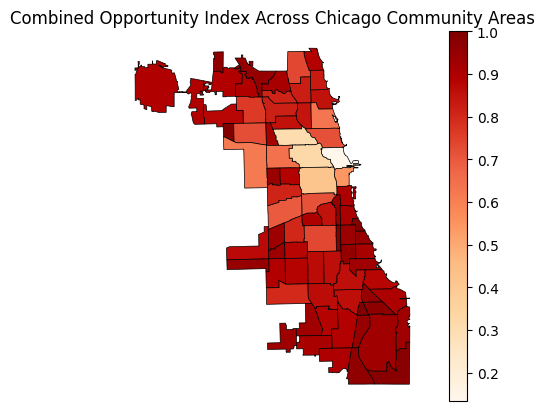

,ca_num,ca_name,business_license_count,food_inspections_count,liquor_license_count,building_permits_count,pct_dependents,pct_working_age,per_capita_income,hardship_index,...,saturation_index,retail_count,school_count,scaled_retail_count,scaled_school_count,bars_undersupply,gyms_undersupply,shops_undersupply,schools_undersupply,combined_opportunity_index
76,47,BURNSIDE,0.0,0.0,0.0,1.0,42.7,57.3,12515.0,79.0,...,0.001802,0.0,1,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
73,18,MONTCLARE,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.012379,0.0,1,0.000000,0.000000,0.986111,1.000000,1.000000,1.000000,0.995833
75,36,OAKLAND,0.0,0.0,0.0,1.0,40.4,59.6,19252.0,78.0,...,0.001802,0.0,2,0.000000,0.043478,1.000000,1.000000,1.000000,0.956522,0.993478
65,37,FULLER PARK,2.0,5.0,1.0,1.0,44.9,55.1,10432.0,97.0,...,0.031816,2.0,1,0.057143,0.000000,0.993056,0.979043,0.942857,1.000000,0.977344
68,55,HEGEWISCH,1.0,3.0,4.0,0.0,42.9,57.1,22677.0,44.0,...,0.023901,1.0,2,0.028571,0.043478,0.972222,0.995469,0.971429,0.956522,0.976643
70,48,CALUMET HEIGHTS,0.0,4.0,1.0,4.0,44.0,56.0,28887.0,38.0,...,0.022111,0.0,5,0.000000,0.173913,0.993056,0.982158,1.000000,0.826087,0.966477
74,54,RIVERDALE,1.0,0.0,0.0,2.0,51.5,48.5,8201.0,98.0,...,0.009556,1.0,5,0.028571,0.173913,1.000000,0.983574,0.971429,0.826087,0.961842
61,9,EDISON PARK,2.0,4.0,2.0,2.0,35.3,64.7,40959.0,8.0,...,0.032496,2.0,3,0.057143,0.086957,0.986111,0.973095,0.942857,0.913043,0.960433
72,40,WASHINGTON PARK,0.0,1.0,3.0,5.0,42.8,57.2,13785.0,88.0,...,0.018464,0.0,6,0.000000,0.217391,0.979167,0.976211,1.000000,0.782609,0.954005
71,50,PULLMAN,1.0,5.0,0.0,0.0,38.6,61.4,20588.0,51.0,...,0.021978,1.0,7,0.028571,0.260870,1.000000,0.995469,0.971429,0.739130,0.952367


In [9]:
# -----------------------------------------------------------
# 8. Choropleth map of combined opportunity index
# -----------------------------------------------------------

plt.figure(figsize=(12, 10))
gdf.plot(
    column="combined_opportunity_index",
    cmap="OrRd",
    legend=True,
    edgecolor="black",
    linewidth=0.5
)
plt.title("Combined Opportunity Index Across Chicago Community Areas")
plt.axis("off")
plt.show()

# Save output
df.to_csv("combined_opportunity_index_by_CA.csv", index=False)

df.sort_values("combined_opportunity_index", ascending=False).head(10)
